# Denoising Diffution Probabilistic Models (DDPM)

* https://arxiv.org/abs/2006.11239

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import IPython.display as display
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2
from tqdm.auto import tqdm

## Dataset

In [2]:
image_size = 24

dataset = MNIST(
    root='../data',
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_size),
        v2.ToDtype(torch.float32, scale=True),  # [0, 255] -> [0, 1]
        v2.Lambda(lambda x: x * 2 - 1),         # [0, 1] -> [-1, 1]
    ]),
)

In [3]:
dataset[0][0].shape

torch.Size([1, 24, 24])

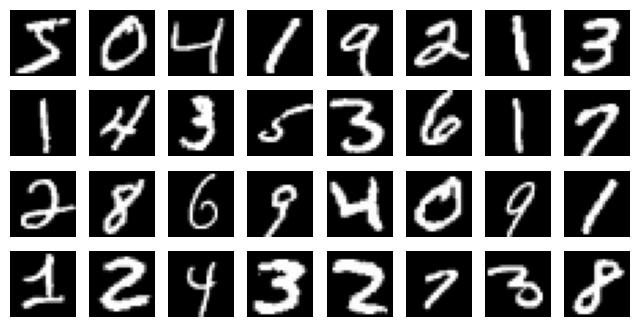

In [4]:
def to_image(x):
    x = x.clamp(-1, 1) * 0.5 + 0.5
    x = x.detach().cpu()
    return v2.functional.to_pil_image(x)

def plot_images(images, ncols=8):
    nrows = (len(images) - 1) // ncols + 1
    plt.figure(figsize=(ncols, nrows))
    for i, x in enumerate(images):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(x, cmap='gray')
        plt.axis('off')
    plt.show()

plot_images([to_image(dataset[i][0]) for i in range(32)])

## Model

In [5]:
def positional_encoding(D=32, T=10000):
    positions = torch.arange(0, T).unsqueeze(1) # (T, 1)
    i = torch.arange(0, D)
    denom = torch.pow(T, i / D).unsqueeze(0)    # (1, D)
    pe = torch.zeros(T, D)                      # (T, D)
    pe[:, 0::2] = torch.sin(positions / denom[:, 0::2])
    pe[:, 1::2] = torch.cos(positions / denom[:, 1::2])
    return pe

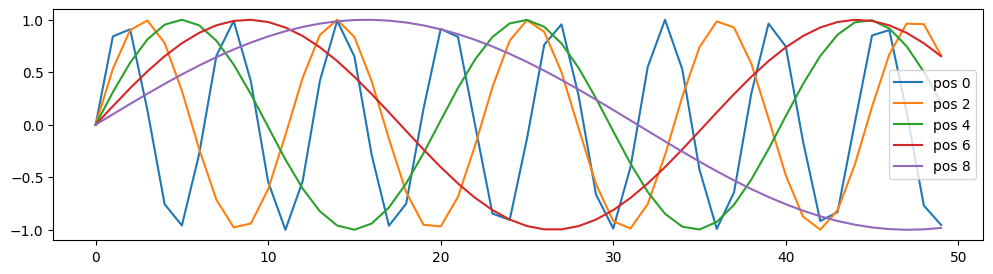

In [6]:
pe = positional_encoding()
plt.figure(figsize=(12, 3))
plt.plot(pe[:50, :10:2].numpy(), label=[f'pos {i}' for i in range(0, 10, 2)])
plt.legend()
plt.show()

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embedding_dim=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.register_buffer('embeddings', positional_encoding(D=embedding_dim))
        self.linear = nn.Linear(embedding_dim, out_channels)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, t):
        batch_size = x.shape[0]
        x = self.conv1(x)
        embedding = self.linear(self.embeddings[t])
        residual = self.conv2(x + embedding.view(batch_size, -1, 1, 1))
        return x + residual


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            ResBlock(1, 64),
            ResBlock(64, 128),
        )
        self.bottom = ResBlock(128, 256)
        self.decoder = nn.Sequential(
            ResBlock(256 + 128, 128),
            ResBlock(128 + 64, 64),
        )
        self.head = nn.Conv2d(64, 1, kernel_size=1)
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, t):
        skips = []
        for block in self.encoder:
            x = block(x, t)
            skips.append(x)
            x = self.downsample(x)
        x = self.bottom(x, t)
        for block in self.decoder:
            x = self.upsample(x)
            skip = skips.pop()
            x = block(torch.cat([x, skip], dim=1), t)
        return self.head(x)

In [8]:
class DDPM(nn.Module):
    def __init__(self, T=1000, min_beta=1e-4, max_beta=0.02):
        super().__init__()
        self.unet = UNet()
        self.T = T
        betas = torch.linspace(min_beta, max_beta, T)
        self.register_buffer('alphas', 1 - betas)
        self.register_buffer('alpha_bars', torch.cumprod(self.alphas, dim=0))

    @property
    def device(self):
        return next(self.parameters()).device

    def diffuse(self, x0, t):
        alpha_bar = self.alpha_bars[t].view(-1, 1, 1, 1)
        e = torch.randn_like(x0, device=x0.device)
        xt = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * e
        return xt, e

    def compute_loss(self, x0):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.T, (batch_size,), device=x0.device)  # 0-based
        xt, e = self.diffuse(x0, t)
        e_pred = self.unet(xt, t)
        return F.mse_loss(e_pred, e)

    def denoise(self, xt, t):
        alpha = self.alphas[t].view(-1, 1, 1, 1)
        alpha_bar = self.alpha_bars[t].view(-1, 1, 1, 1)
        alpha_bar_prev = self.alpha_bars[t - 1].view(-1, 1, 1, 1)

        with torch.no_grad():
            e_pred = self.unet(xt, t)
        mu = (xt - (1 - alpha) / torch.sqrt(1 - alpha_bar) * e_pred) / torch.sqrt(alpha)
        sigma = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))

        noise = torch.randn_like(xt, device=xt.device)
        noise[t == 0] = 0

        return mu + sigma * noise

    def sample(self, n=32):
        x = torch.randn(n, 1, image_size, image_size, device=self.device)
        for i in tqdm(reversed(range(0, self.T)), total=self.T):
            t = torch.tensor([i] * n, device=self.device)
            x = self.denoise(x, t)
        return [to_image(x[i]) for i in range(n)]

## Training

In [9]:
def plot_losses(values_dict):
    n = len(values_dict)
    display.clear_output(wait=True)
    plt.figure(figsize=(5 * n, 3))
    for i, (label, values) in enumerate(values_dict.items()):
        plt.subplot(1, n, i + 1)
        plt.plot(values)
        plt.grid(True)
        plt.xlabel(label)
        plt.ylabel('Loss')
    plt.show()

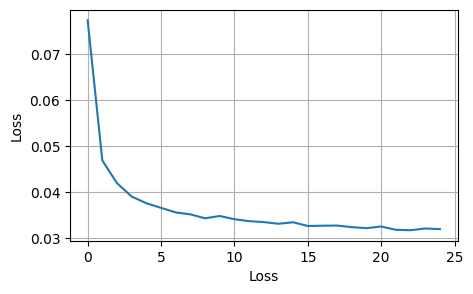

In [10]:
epochs = 25
batch_size = 128
learning_rate = 4e-4

model = DDPM()
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train()
losses = []
for epoch in range(epochs):
    epoch_losses = []
    for x, _ in dataloader:
        x = x.to(device)

        optimizer.zero_grad()
        loss = model.compute_loss(x)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    losses.append(sum(epoch_losses) / len(epoch_losses))
    plot_losses({'Loss': losses})

## Sampling

  0%|          | 0/1000 [00:00<?, ?it/s]

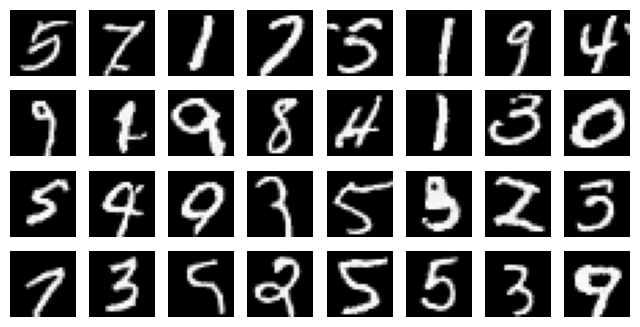

In [11]:
model.eval()
images = model.sample(32)
plot_images(images)